In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm.rumbooster import rum_train

from sklearn.model_selection import train_test_split

In [6]:
a = [[0, 1], [3, 4], [2, 3]]
b = np.array(a).T.tolist()
b

[[0, 3, 2], [1, 4, 3]]

In [2]:
swissmetro = pd.read_table('Data/swissmetro.dat')

keep = (( swissmetro['PURPOSE'] != 1 ) * ( swissmetro['PURPOSE'] != 3 ) + ( swissmetro['CHOICE'] == 0 )) == 0
#swissmetro.drop(swissmetro[exclude].index, inplace=True).reset_index(inplace=True, drop=True)
swissmetro = swissmetro[keep]

In [3]:
new_train_co = swissmetro['TRAIN_CO'] * (swissmetro['GA']==0)
new_sm_co = swissmetro['SM_CO'] * (swissmetro['GA']==0)

In [4]:
feature = swissmetro[['TRAIN_TT', 'TRAIN_CO', 'TRAIN_HE', 'SM_TT', 'SM_CO', 'SM_HE', 'CAR_TT', 'CAR_CO']]

In [5]:
feature['TRAIN_CO'] = new_train_co
feature['SM_CO'] = new_sm_co

C:\Users\nicol\AppData\Local\Temp\ipykernel_23824\958357240.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature['TRAIN_CO'] = new_train_co
C:\Users\nicol\AppData\Local\Temp\ipykernel_23824\958357240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature['SM_CO'] = new_sm_co


In [6]:
choice = swissmetro[['CHOICE']] -1

In [7]:
X_train, X_test, y_train, y_test = train_test_split(feature, choice, test_size=0.2, random_state = 42)

In [8]:
param = {'max_depth': 2, 
         'num_boost_round': 3, 
         'objective':'multiclass',
         'monotone_constraints': [-1, -1, -1, -1, -1, -1, -1, -1], 
         'interaction_constraints': [[0], [1], [2], [3], [4], [5], [6], [7]],
         'learning_rate': 0.1,
         'verbosity': 2,
         'num_classes': 3
        }

In [9]:
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
validation_data = lgb.Dataset(X_test, label=y_test, reference= train_data, free_raw_data=False)

In [10]:
rum_structure_1= [{'columns': ['TRAIN_TT', 'TRAIN_CO', 'TRAIN_HE'], 
                  'monotone_constraints': [-1, -1, -1], 
                  'interaction_constraints': [[0], [1], [2]]}, 
                 {'columns': ['SM_TT', 'SM_CO', 'SM_HE'], 
                  'monotone_constraints': [-1, -1, -1], 
                  'interaction_constraints': [[0], [1], [2]]},
                 {'columns': ['CAR_TT', 'CAR_CO'], 
                  'monotone_constraints': [-1, -1], 
                  'interaction_constraints': [[0], [1]]}]

In [11]:
lightgbm_1 = rum_train(param, train_data, valid_sets=[validation_data], rum_structure= rum_structure_1)

c:\Users\nicol\Anaconda3\envs\lightgbm\Lib\site-packages\lightgbm\rumbooster.py:534: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\nicol\Anaconda3\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\nicol\Anaconda3\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
c:\Users\nicol\Anaconda3\envs\lightgbm\Lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


[LightGBM] [Info] Number of positive: 747, number of negative: 4667
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.044884
[LightGBM] [Debug] init for col-wise cost 0.000008 seconds, init for row-wise cost 0.000113 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 5414, number of used features: 3
[LightGBM] [Info] Number of positive: 3250, number of negative: 2164
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.044884
[LightGBM] [Debug] init for col-wise cost 0.000006 seconds, init for row-wise cost 0.000228 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You 

LightGBMError: The number of features in data (8) is not the same as it was in training data (3).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

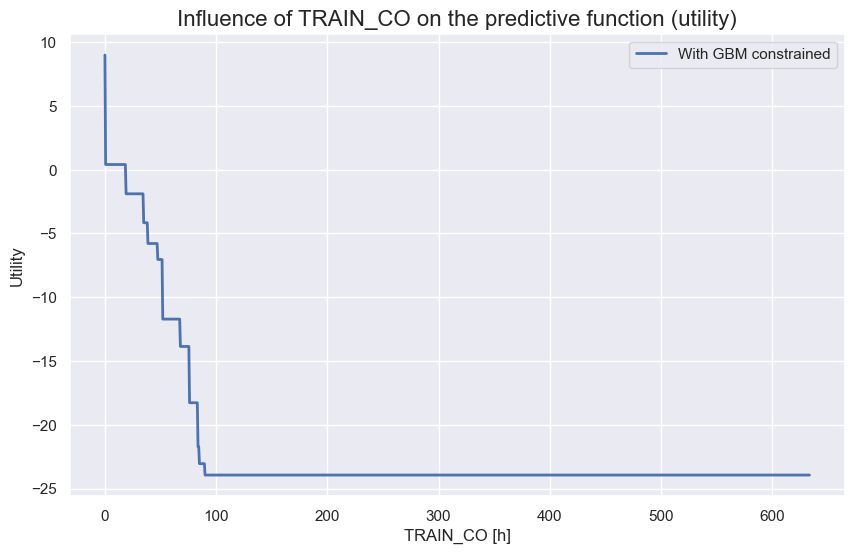

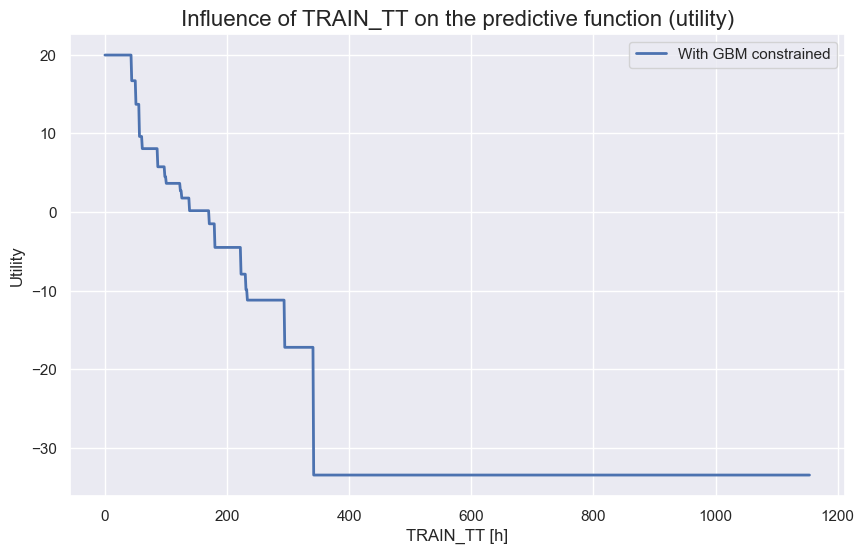

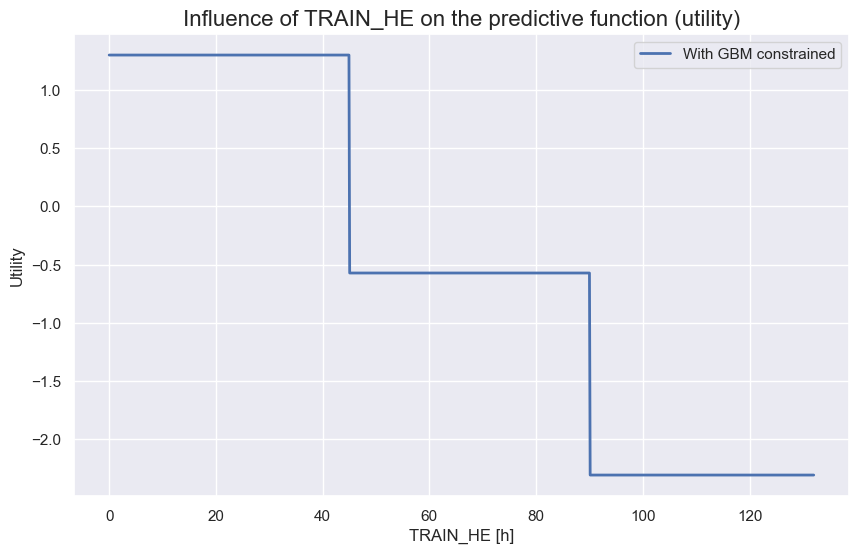

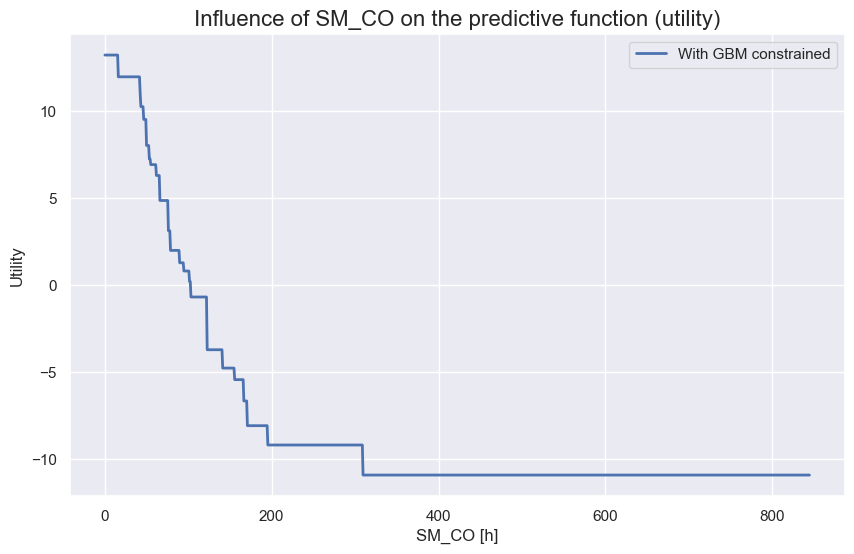

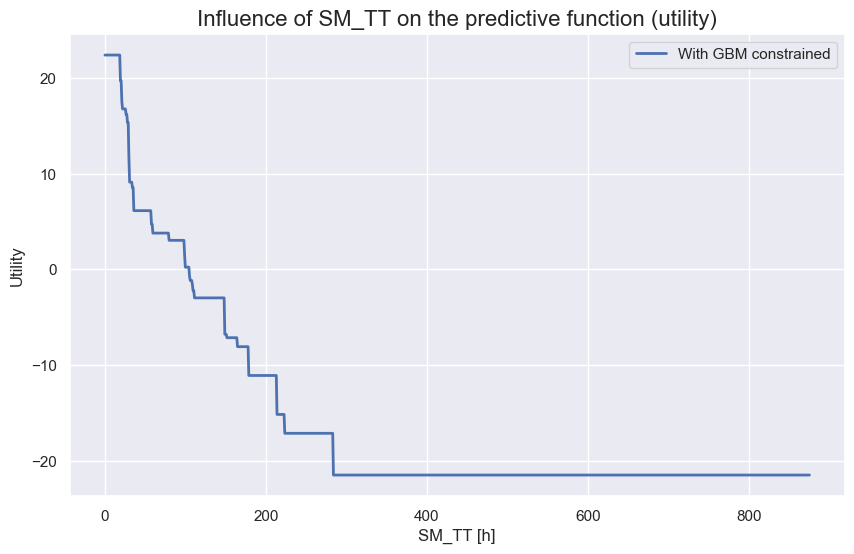

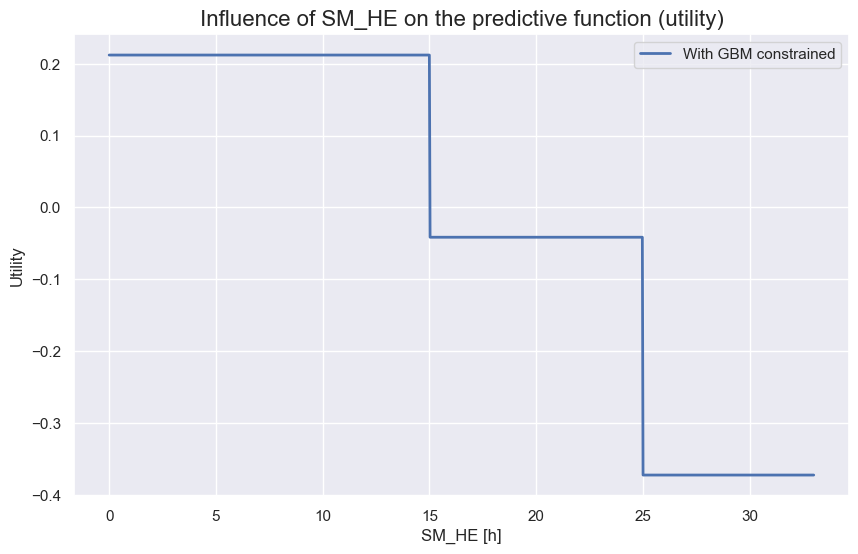

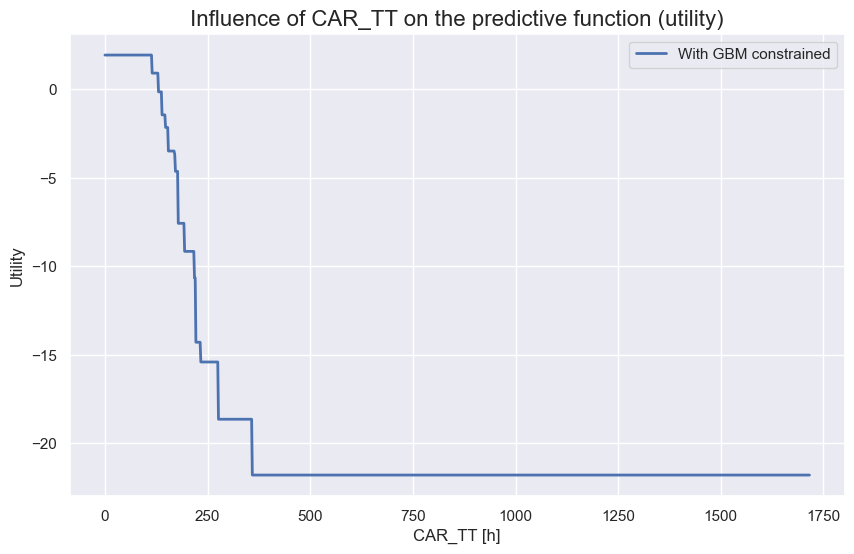

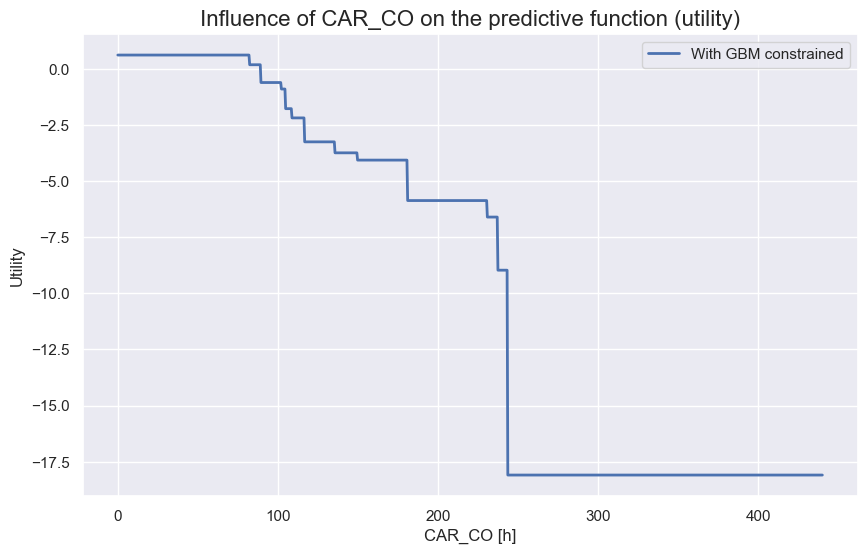

In [43]:
lightgbm_1.plot_parameters(param, X_train, ['h', 'h', 'h', 'h', 'h', 'h', 'h', 'h'])

In [21]:
%run -i "Base_Model.py"

Obsolete syntax. Use generate_html instead of generateHtml
Obsolete syntax. Use generate_pickle instead of generatePickle


            Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_CAR  0.212685      0.090920     2.339243      0.019323
ASC_SM   0.510729      0.109986     4.643591      0.000003
B_COST  -0.011023      0.000762   -14.461293      0.000000
B_HE    -0.005344      0.001103    -4.843324      0.000001
B_TIME  -0.012116      0.001239    -9.778750      0.000000
Nbr of observations: 5390
LL(0) = -4229.657
LL(beta) = -4229.657
rho bar square = -0.00118
Output file: None
